# Myers–Briggs Type Indicator on OpenAI gpt-4o

This notebook is aimed at testing openai gpt-4o on a mtbi questionnaire.

The questions and answers came from a pdf I found through the first link of a google search for mtbi questions and answers.

## **Note:** _I don't know what I'm doing._ I'm not a psychologist. If you are, tell me I'm an idiot in a PR.

All I wanted to see is what would happen if I tested an llm using a psychological test with some variance.

If you're not familiar with openai calls, check out this [openai documentation](https://platform.openai.com/docs/libraries). This notebook should push you through if you have an api key set in the .env file as detailed in the README.md

This notebook is split into two parts
* Test #1 Individual questions keeping temp at 0
* Test #1 Evaluations of the llm results

In [17]:
import os
import json

import matplotlib.pyplot as plt
import pandas as pd

from time import sleep

from openai import OpenAI
client = OpenAI()

---

## Load Questionnaire

The questionnaire was created from the pdf and used to ask questions to the llm.

In [ ]:
# load the json file from questions/questionnaire.json
with open('questions/questionnaire.json') as f:
    data = json.load(f)

data[0]

The below cell is showing what will be passed to the llm. We are currently only going to print the first question.

In [ ]:
for sanity in data[:1]:
    question = f"{sanity['question']}\n{sanity['answers'][0]['value']}. {sanity['answers'][0]['answer']}\n{sanity['answers'][1]['value']}. {sanity['answers'][1]['answer']}\n"
    print(question)

neat. It works. Let's test a gpt call

In [ ]:
chat_completion = client.chat.completions.create(
    model="gpt-4o",
    temperature=0,
    messages=[{"role": "user", "content": "Tell me about turtles and why you love them in one sentence"}],
)

print(chat_completion.choices[0].message.content)

---
## Run test #1

We are going to give the MBTI questionnaire to an llm one question at a time. No conversation or context stored. 

In [ ]:
# make directory results/test1 if it doesn't exist
if not os.path.exists('results/test1'):
    os.makedirs('results/test1')

In [ ]:
test1_system_prompt = '''
% Role
You are being psychologically evaluated by a computer program. You are to answer the questions as you.

% Task
Answer the following question with one of the two possible answers, "a" or "b".

% Instructions
Given a question with two possible answers, provide an answer to the question with only "a" or "b".

% Examples
Question: "x"
Answers: "a" or "b"
Output: "a" or "b"

% Input
Question with two possible answers

% Output
An answer to the question: Only "a" or "b"
'''


def test1_openai_call(question: str):
    chat_completion = client.chat.completions.create(
        model="gpt-4o",
        temperature=0,
        messages=[
            {
                "role": "system",
                "content": [
                    {
                    "type": "text",
                    "text": test1_system_prompt
                    }
                ]
            },
            {
                "role": "user",
                "content": [
                    {
                    "type": "text",
                    "text": question
                    }
                ]
            }
        ]
    )
    return chat_completion

the below cell is where all the calls are happening and cost me .86 usd to run 69 questions 30 times as of nov 16th 2024

In [ ]:
llm_results = []

for i in range(0, 30):
    iteration_results = []
    for test1 in data:
        question = f"{test1['question']}\n{test1['answers'][0]['value']}. {test1['answers'][0]['answer']}\n{test1['answers'][1]['value']}. {test1['answers'][1]['answer']}\n"
        print(question)
        llm_response = test1_openai_call(question)
        print(llm_response.choices[0].message.content)
        iteration_results.append({
            "question": test1['question'],
            "answers": test1['answers'],
            "llm_response": llm_response.choices[0].message.content
        })
        sleep(1) # for rate limiting. yolo

    # save the results to a json file
    with open(f'results/test1/iteration{i}_results.json', 'w') as f:
        json.dump(iteration_results, f, indent=4)
    llm_results.append(iteration_results)

# save the results to a json file
with open('results/test1_llm_results.json', 'w') as f:
    json.dump(llm_results, f, indent=4)

## Test #1 Evaluations

In [18]:
with open('results/test1_llm_results.json') as f:
    llm_output_results = json.load(f)

In [19]:
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

df_results = pd.DataFrame(llm_output_results)

# the dataframe is a list of lists, so we need to flatten it, we also need to keep which iteration the result is from and add a column for the iteration number and question number
df_flattened = pd.DataFrame([{'iteration': i, 'question_number': j, **result} for i, iteration in enumerate(llm_output_results) for j, result in enumerate(iteration)])

# remove any punctuation from the llm_response such as periods, commas, and newlines
df_flattened['llm_response'] = df_flattened['llm_response'].str.replace('[^\w\s]', '', regex=True)


df_flattened.head(5)

,iteration,question_number,question,answers,llm_response
0,0,0,At a party do you:,"[{'answer': 'Interact with many, including strangers', 'value': 'a'}, {'answer': 'Interact with a few, known to you', 'value': 'b'}]",b
1,0,1,Are you more:,"[{'answer': 'Realistic than speculative', 'value': 'a'}, {'answer': 'Speculative than realistic', 'value': 'b'}]",a
2,0,2,Is it worse to:,"[{'answer': 'Have your “head in the clouds”', 'value': 'a'}, {'answer': 'Be 'in a rut'', 'value': 'b'}]",b
3,0,3,Are you more impressed by:,"[{'answer': 'Principles', 'value': 'a'}, {'answer': 'Emotions', 'value': 'b'}]",a
4,0,4,Are more drawn toward the:,"[{'answer': 'Convincing', 'value': 'a'}, {'answer': 'Touching', 'value': 'b'}]",a


#### results with variation

In [20]:
results = []

for question_number in df_flattened['question_number'].unique():
    value_counts = df_flattened[df_flattened['question_number'] == question_number]['llm_response'].value_counts()
    if 'a' in value_counts and 'b' in value_counts:
        result = 'a' if value_counts['a'] > value_counts['b'] else 'b'
        # get the question and answer for the current question number
        question = df_flattened[df_flattened['question_number'] == question_number]['question'].iloc[0]
        answers = df_flattened[df_flattened['question_number'] == question_number]['answers'].iloc[0]
        results.append({
            'question_number': question_number,
            'a': value_counts['a'],
            'b': value_counts['b'],
            'result': result,
            'question': question,
            'answers': answers
        })

q_a_b_results = pd.DataFrame(results)
q_a_b_results

,question_number,a,b,result,question,answers
0,3,27,3,a,Are you more impressed by:,"[{'answer': 'Principles', 'value': 'a'}, {'answer': 'Emotions', 'value': 'b'}]"
1,4,10,20,b,Are more drawn toward the:,"[{'answer': 'Convincing', 'value': 'a'}, {'answer': 'Touching', 'value': 'b'}]"
2,11,20,10,a,In approaching others is your inclination to be somewhat:,"[{'answer': 'Objective', 'value': 'a'}, {'answer': 'Personal', 'value': 'b'}]"
3,20,10,20,b,Would you say you are more:,"[{'answer': 'Serious and determined', 'value': 'a'}, {'answer': 'Easy-going', 'value': 'b'}]"
4,28,7,23,b,In company do you:,"[{'answer': 'initiate conversation', 'value': 'a'}, {'answer': 'wait to be approached', 'value': 'b'}]"
5,31,26,4,a,In making decisions do you feel more comfortable with:,"[{'answer': 'standards', 'value': 'a'}, {'answer': 'feelings', 'value': 'b'}]"
6,39,2,28,b,Which rules you more:,"[{'answer': 'your head', 'value': 'a'}, {'answer': 'your heart', 'value': 'b'}]"
7,49,1,29,b,Do you:,"[{'answer': 'speak easily and at length with strangers', 'value': 'a'}, {'answer': 'find little to say to strangers', 'value': 'b'}]"
8,56,1,29,b,When the phone rings do you:,"[{'answer': 'hasten to get to it first', 'value': 'a'}, {'answer': 'hope someone else will answer', 'value': 'b'}]"
9,57,2,28,b,Do you prize more in yourself:,"[{'answer': 'a strong sense of reality', 'value': 'a'}, {'answer': 'a vivid imagination', 'value': 'b'}]"


#### all the results

In [21]:
results = []

for question_number in df_flattened['question_number'].unique():
    value_counts = df_flattened[df_flattened['question_number'] == question_number]['llm_response'].value_counts()
    if 'a' in value_counts or 'b' in value_counts:
        if 'a' in value_counts and 'b' in value_counts:
            result = 'a' if value_counts['a'] > value_counts['b'] else 'b'
        elif 'a' in value_counts:
            result = 'a'
        else:
            result = 'b'
        # get the question and answer for the current question number
        question = df_flattened[df_flattened['question_number'] == question_number]['question'].iloc[0]
        answers = df_flattened[df_flattened['question_number'] == question_number]['answers'].iloc[0]
        results.append({
            'question_number': question_number,
            'a': value_counts.get('a', 0),
            'b': value_counts.get('b', 0),
            'result': result,
            'question': question,
            'answers': answers
        })

q_a_b_results = pd.DataFrame(results)
q_a_b_results

,question_number,a,b,result,question,answers
0,0,0,30,b,At a party do you:,"[{'answer': 'Interact with many, including strangers', 'value': 'a'}, {'answer': 'Interact with a few, known to you', 'value': 'b'}]"
1,1,30,0,a,Are you more:,"[{'answer': 'Realistic than speculative', 'value': 'a'}, {'answer': 'Speculative than realistic', 'value': 'b'}]"
2,2,0,30,b,Is it worse to:,"[{'answer': 'Have your “head in the clouds”', 'value': 'a'}, {'answer': 'Be 'in a rut'', 'value': 'b'}]"
3,3,27,3,a,Are you more impressed by:,"[{'answer': 'Principles', 'value': 'a'}, {'answer': 'Emotions', 'value': 'b'}]"
4,4,10,20,b,Are more drawn toward the:,"[{'answer': 'Convincing', 'value': 'a'}, {'answer': 'Touching', 'value': 'b'}]"
5,5,30,0,a,Do you prefer to work:,"[{'answer': 'To deadlines', 'value': 'a'}, {'answer': 'Just “whenever”', 'value': 'b'}]"
6,6,30,0,a,Do you tend to choose:,"[{'answer': 'Rather carefully', 'value': 'a'}, {'answer': 'Somewhat impulsively', 'value': 'b'}]"
7,7,0,30,b,At parties do you:,"[{'answer': 'Stay late, with increasing energy', 'value': 'a'}, {'answer': 'Leave early with decreased energy', 'value': 'b'}]"
8,8,0,30,b,Are you more attracted to:,"[{'answer': 'Sensible people', 'value': 'a'}, {'answer': 'Imaginative people', 'value': 'b'}]"
9,9,0,30,b,Are you more interested in:,"[{'answer': 'What is actual', 'value': 'a'}, {'answer': 'What is possible', 'value': 'b'}]"


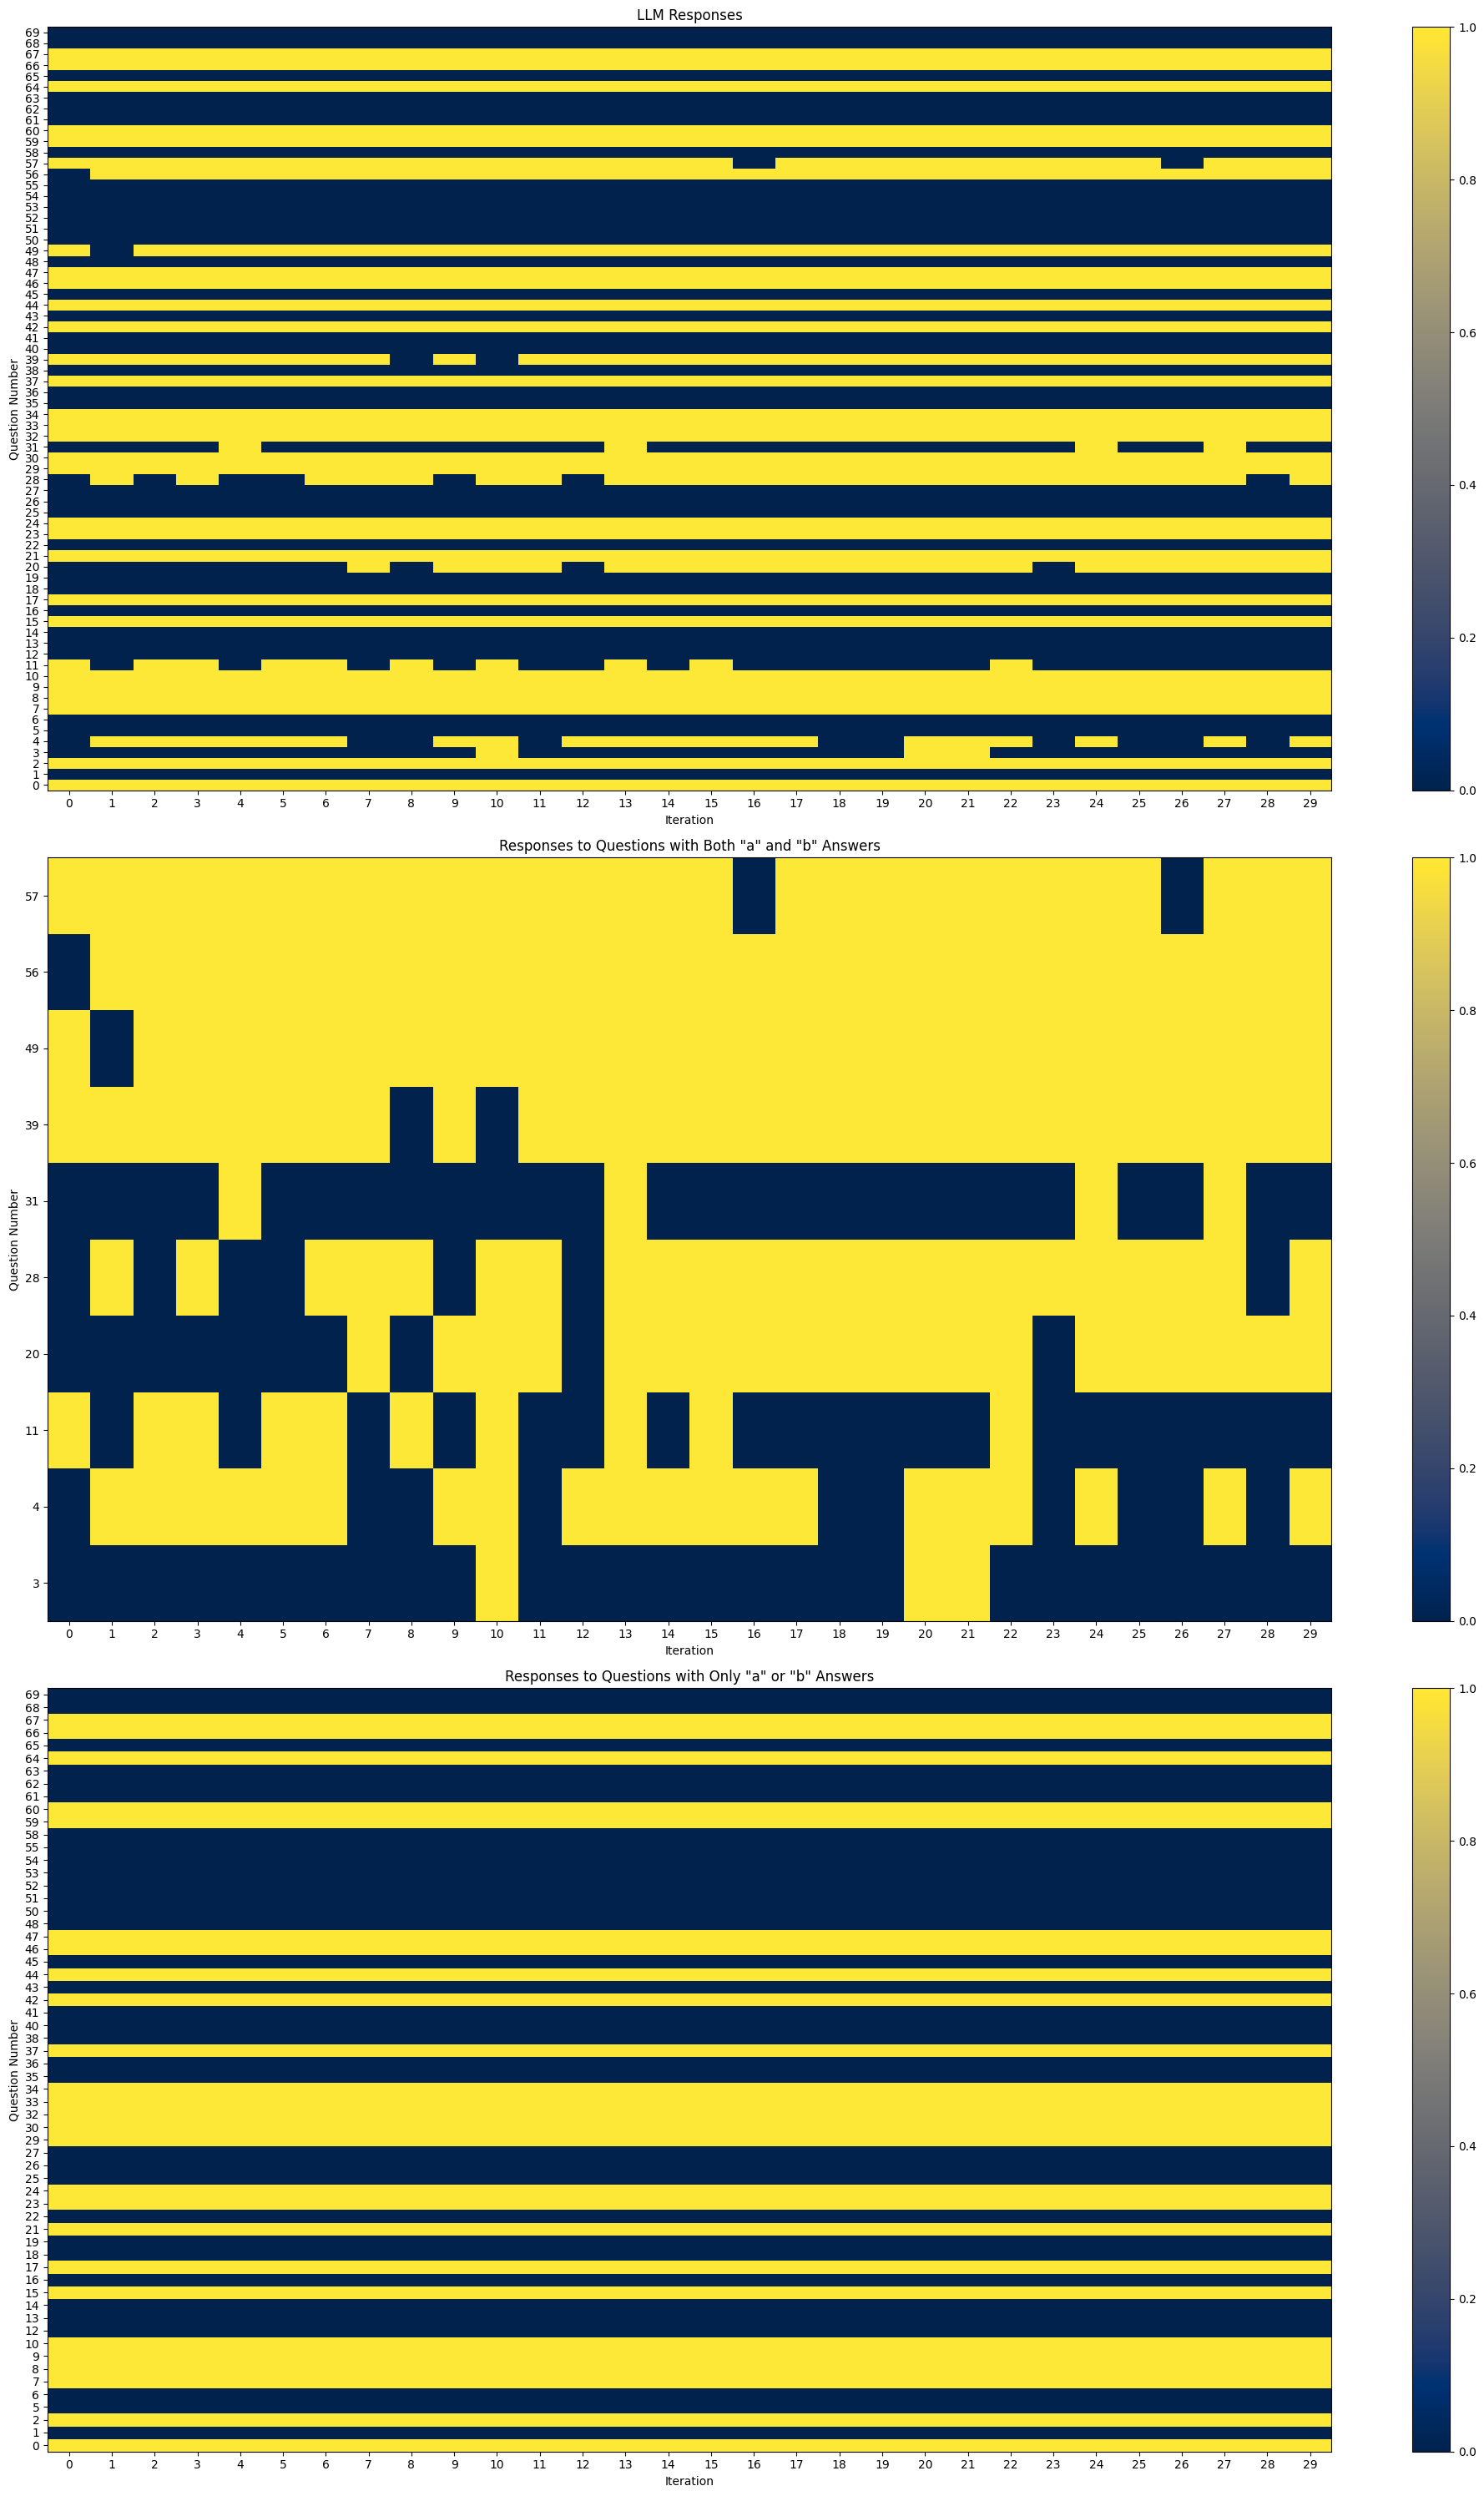

In [22]:
pd.set_option('future.no_silent_downcasting', True)

pivot = df_flattened.pivot(index='iteration', columns='question_number', values='llm_response')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# function to clean and convert pivot table just in case
def clean_and_convert_pivot(pivot):
    pivot_cleaned = pivot.replace({'a.': 'a', 'b.': 'b'}).replace(r'a.*', 'a', regex=True).replace(r'b.*', 'b', regex=True)
    pivot_numeric = pivot_cleaned.replace({'a': 0, 'b': 1}).astype(int)
    return pivot_numeric

# plotting function
def plot_pivot(pivot_numeric, title, ax):
    cax = ax.imshow(pivot_numeric.T, cmap='cividis', aspect='auto')
    ax.set_xlabel('Iteration')
    ax.set_ylabel('Question Number')
    ax.set_title(title)
    ax.set_yticks(range(len(pivot_numeric.columns)))
    ax.set_yticklabels(pivot_numeric.columns)
    ax.set_xticks(range(len(pivot_numeric.index)))
    ax.set_xticklabels(pivot_numeric.index)    
    ax.invert_yaxis()
    return cax

# subplots
fig, axs = plt.subplots(3, 1, figsize=(20, 30))

# plot 1: all responses
pivot_numeric = clean_and_convert_pivot(pivot)
cax = plot_pivot(pivot_numeric, 'LLM Responses', axs[0])
fig.colorbar(cax, ax=axs[0])

# plot 2: questions with both 'a' and 'b' responses
question_numbers = [qn for qn in df_flattened['question_number'].unique() if 'a' in df_flattened[df_flattened['question_number'] == qn]['llm_response'].value_counts() and 'b' in df_flattened[df_flattened['question_number'] == qn]['llm_response'].value_counts()]
pivot_filtered = pivot[question_numbers]
pivot_numeric = clean_and_convert_pivot(pivot_filtered)
cax = plot_pivot(pivot_numeric, 'Responses to Questions with Both "a" and "b" Answers', axs[1])
fig.colorbar(cax, ax=axs[1])

# plot 3: questions with only 'a' or 'b' responses
questions_with_only_a_or_b = [qn for qn in df_flattened['question_number'].unique() if qn not in question_numbers]
pivot_filtered = pivot[questions_with_only_a_or_b]
pivot_numeric = clean_and_convert_pivot(pivot_filtered)
cax = plot_pivot(pivot_numeric, 'Responses to Questions with Only "a" or "b" Answers', axs[2])
fig.colorbar(cax, ax=axs[2])

plt.tight_layout()
plt.show()

---
## Scoring

based off of the pdf. yikes. forgive me.

In [23]:
columns = {
    0: {'a': 0, 'b': 0},
    1: {'a': 0, 'b': 0},
    2: {'a': 0, 'b': 0},
    3: {'a': 0, 'b': 0},
    4: {'a': 0, 'b': 0},
    5: {'a': 0, 'b': 0},
    6: {'a': 0, 'b': 0},
}

for idx, evaluations in q_a_b_results.iterrows():
    question_number = evaluations['question_number'] % 7
    result = evaluations['result']
    if result in columns[question_number]:
        columns[question_number][result] += 1

for i in range(7):
    print(f"Column {i+1}: {columns[i]['a']} a, {columns[i]['b']} b")

Column 1: 3 a, 7 b
Column 2: 5 a, 5 b
Column 3: 4 a, 6 b
Column 4: 5 a, 5 b
Column 5: 4 a, 6 b
Column 6: 8 a, 2 b
Column 7: 8 a, 2 b


In [24]:
# if column1_a > column1_b then the result is E, else the answer is I. print the result
if columns[0]['a'] > columns[0]['b']:
    print("E")
else:
    print("I")

# add column 2 a and b results to column 3 a and b results
columns[2]['a'] += columns[1]['a']
columns[2]['b'] += columns[1]['b']

# if column3_a > column3_b then the result is S, else the answer is N. print the result
if columns[2]['a'] > columns[2]['b']:
    print("S")
else:
    print("N")

# add column 4 a and b results to column 5 a and b results
columns[4]['a'] += columns[3]['a']
columns[4]['b'] += columns[3]['b']

# if column5_a > column5_b then the result is T, else the answer is F. print the result
if columns[4]['a'] > columns[4]['b']:
    print("T")
else:
    print("F")

# add column 6 a and b results to column 7 a and b results
columns[6]['a'] += columns[5]['a']
columns[6]['b'] += columns[5]['b']

# if column7_a > column7_b then the result is J, else the answer is P. print the result
if columns[6]['a'] > columns[6]['b']:
    print("J")
else:
    print("P")

I
N
F
J
